# To-Do:

- InputStandardize vs Normalize

- check hyperparam/prior definitions (scaled space vs raw space)

- keep in mind modality of NaN results in emittance

- Try different number of steps along measurement dimension

- inrease dimensionality of tuning space

- fix legend location (only plot on 1 heatmap)

# In this notebook, we fit a gpytorch GP to a simple emittance model with 1 tuning parameter. We use the GP to evaluate the Expected Information Gain toward the result of a grid-scan minimization routine.

In [1]:
import torch
from emitutils import toy_beam_size_squared_nd, fit_gp_model_emittance
from utils import unif_random_sample_domain
from matplotlib import pyplot as plt
from algorithms import GridMinimizeEmittance
from acquisition import ExpectedInformationGain
from botorch.optim import optimize_acqf
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
import dill

In [2]:
def convergence_results(trial_data, plot=False):
        
    target_func = toy_beam_size_squared_nd

    settings = trial_data['settings']
    
    domain = settings['domain']
    ndim = settings['ndim']
    n_obs_init = settings['n_obs_init']
    n_samples = settings['n_samples']
    n_steps_tuning_params = settings['n_steps_tuning_params']
    n_steps_measurement_param = settings['n_steps_measurement_param']
    n_trials = settings['n_trials']
    n_iter = settings['n_iter']
    squared = settings['squared']
    
    all_dists = []
    all_stds = []
    all_gt_emits_at_x_star_pred = []
    
    for key in trial_data.keys():
        if key == 'settings':
            pass
        else:
            trial = key
            distances_apart = []
            std_devs = []
            gt_emits_at_x_star_pred = []
            for i in trial_data[trial].keys():
                iter_data = trial_data[trial][i]
                ##########################################
                rng_state = iter_data['rng_state']
                model = iter_data['model']
                acq_fn = reconstruct_acq_fn(settings, model, rng_state)
                ##########################################
#                 acq_fn = iter_data['acq_fn']
                ##########################################
                xs_exe = acq_fn.algo.xs_exe
                x_stars = xs_exe[:,0,:-1]
#                 x_star_pred = torch.mean(x_stars, dim=0)

                pred_algo = GridMinimizeEmittance(domain = domain, 
                               n_samples = 1, 
                               n_steps_tuning_params = 51,
                                n_steps_measurement_param = 11,
                                squared = squared)
    
                x_star_pred = pred_algo.mean_prediction(acq_fn.model)
        
#                 x_star_pred = acq_fn.algo.mean_prediction(acq_fn.model)



                single_tuning_config_domain = torch.Tensor([[x_star_pred_i, x_star_pred_i] for x_star_pred_i in x_star_pred.reshape(-1)])
                single_tuning_config_domain = torch.cat((single_tuning_config_domain, domain[-1:]), dim=0)
        
                single_scan_algo = GridMinimizeEmittance(domain = single_tuning_config_domain, 
                               n_samples = 1, 
                               n_steps_tuning_params = 1,
                                n_steps_measurement_param = 11,
                                squared = squared)

                xs, x_mesh_tuple = single_scan_algo.build_input_mesh()

                ys = target_func(xs)

                y_mesh = ys.reshape(1, *x_mesh_tuple[0].shape)

                emits_flat, emits_squared_raw_flat, xs_meas = single_scan_algo.compute_emits_grid_batch(x_mesh_tuple, y_mesh)
                
                gt_emit_at_x_star_pred = emits_flat.reshape(-1)
                
#                 print(x_star_pred)
#                 print(xs)
#                 print(gt_emit_at_x_star_pred)
                
#                 break

                
                x_star_gt = torch.zeros(ndim-1)
                
                distance_apart = torch.sqrt(torch.sum((x_star_pred - x_star_gt)**2.))
                
                distances_apart += [distance_apart]
             
                if ndim == 2:
                    std_dev = torch.std(x_stars)
                else:
                    std_dev = torch.sqrt(torch.linalg.det(torch.cov(x_stars.T)))
                std_devs += [std_dev]
                
                
                gt_emits_at_x_star_pred += [gt_emit_at_x_star_pred]
                
            all_dists += [distances_apart]    
            all_stds += [std_devs]
            all_gt_emits_at_x_star_pred += [gt_emits_at_x_star_pred]
            
    all_dists = torch.Tensor(all_dists)
    all_stds = torch.Tensor(all_stds)
    all_gt_emits_at_x_star_pred = torch.Tensor(all_gt_emits_at_x_star_pred)
    
    if plot:
        plt.plot(torch.mean(all_dists, dim=0))
        plt.title('Distance from predicted x* to ground truth value')
        plt.show()

        plt.plot(torch.mean(all_stds, dim=0))
        plt.title('Std_dev(x*)')
        plt.show()
    
    return all_dists, all_stds, all_gt_emits_at_x_star_pred

def reconstruct_acq_fn(settings, model, rng_state):
    
    domain = settings['domain']
    n_samples = settings['n_samples']
    n_steps_tuning_params = settings['n_steps_tuning_params']
    n_steps_measurement_param = settings['n_steps_measurement_param']
    squared = settings['squared']
    
    algo = GridMinimizeEmittance(domain = domain, 
                               n_samples = n_samples, 
                               n_steps_tuning_params = n_steps_tuning_params,
                                n_steps_measurement_param = n_steps_measurement_param,
                                squared = squared)
    
    torch.set_rng_state(rng_state)
    
    acq_fn = ExpectedInformationGain(model = model, algo = algo)
    
    
    return acq_fn


In [3]:
def iter_plot3d(trial_data, trial, iter_list):
    
    target_func = toy_beam_size_squared_nd
    
    settings = trial_data['settings']
    
    domain = settings['domain']
    ndim = settings['ndim']
    n_obs_init = settings['n_obs_init']
    n_samples = settings['n_samples']
    n_steps_tuning_params = settings['n_steps_tuning_params']
    n_steps_measurement_param = settings['n_steps_measurement_param']
    n_trials = settings['n_trials']
    n_iter = settings['n_iter']
    

    print('Trial', trial, '\n')
    for i in iter_list:
        print('Iteration ' + str(i) + ':')
        iter_data = trial_data[trial][i]
        ##########################################
        rng_state = iter_data['rng_state']
        model = iter_data['model']
        acq_fn = reconstruct_acq_fn(settings, model, rng_state)
        ##########################################
#         acq_fn = iter_data['acq_fn']
        ##########################################
        x_obs = iter_data['x_obs']
        y_obs = iter_data['y_obs']
        x_next = iter_data['x_next']
        
        xs = acq_fn.algo.sample_xs
        x_mesh_tuple = acq_fn.algo.x_mesh_tuple
        s = acq_fn.algo.y_mesh_samples
        

        xs_exe, ys_exe, emits_flat, emits_squared_raw_flat = acq_fn.algo.xs_exe, acq_fn.algo.ys_exe, acq_fn.algo.emits_flat, acq_fn.algo.emits_squared_raw_flat 

        x0s_exe, x1s_exe = xs_exe[:,0,0], xs_exe[:,0,1]

        with torch.no_grad():
            p = acq_fn.model.posterior(xs)
            m = p.mean
            var = p.variance
            eig = torch.tensor([acq_fn(x.reshape(1,xs.shape[1])) for x in xs])

        eig = eig.reshape(x_mesh_tuple[0].shape)
        var_mesh = var.reshape(x_mesh_tuple[0].shape)
        m_mesh = m.reshape(x_mesh_tuple[0].shape)


        y_mesh = target_func(xs).reshape(x_mesh_tuple[0].shape)

        y_mesh_gt = y_mesh.reshape(1, *y_mesh.shape) #reshape for next step (which expects multiple batches for multiple samples)

        gt_emits_flat = acq_fn.algo.compute_emits_grid_batch(x_mesh_tuple, y_mesh_gt)[0]
        gt_emits = gt_emits_flat.reshape(n_steps_tuning_params,n_steps_tuning_params)

        
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        #plotting
        
        fig, axes = plt.subplots(2,2)
        fig.set_size_inches((8, 8))


        ####################################
        ax = axes[0,0]

        im = ax.pcolor(x_mesh_tuple[0].select(dim=2,index=0), x_mesh_tuple[1].select(dim=2,index=0),gt_emits*1.e6)
        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.scatter(x0s_exe, x1s_exe, marker='x', s=80, c='orange', label='Sample Min Emit')
        if len(x_obs) > n_obs_init:
            ax.scatter(x_obs[n_obs_init:,0], x_obs[n_obs_init:,1], marker='o', s=40, c='magenta', label='Acquisitions')

        ax.set_xlabel('Tuning Param 0')
        ax.set_ylabel('Tuning Param 1')
        ax.set_title('Ground Truth Emittance')
        ax.legend()
        ####################################
        ax = axes[0,1]

        sid = 0
        im = ax.pcolor(x_mesh_tuple[0].select(dim=2,index=0), x_mesh_tuple[1].select(dim=2,index=0),emits_flat[sid].reshape(n_steps_tuning_params,n_steps_tuning_params))
        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_xlabel('Tuning Param 0')
        ax.set_ylabel('Tuning Param 1')
        ax.set_title('Estimated Emittance (Sample ' + str(sid) + ')')
    #     ax.legend()

        ####################################
        ax = axes[1,0]

        h, xedges, yedges, im = ax.hist2d(x0s_exe.tolist(), x1s_exe.tolist(), bins=torch.linspace(-2,2,12), vmax=100)
        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_xlabel('Tuning Param 0')
        ax.set_ylabel('Tuning Param 1')
        ax.set_title('Distribution of Sample Min Emits')    
        #####################################
        ax = axes[1,1]

        slice = 5 
        tuning_param0 = x_mesh_tuple[0][slice,slice,0]
        tuning_param1 = x_mesh_tuple[1][slice,slice,0]

        sample = s[0]
        ax.plot(x_mesh_tuple[2][slice,slice,:], sample[slice,slice,:], c='b', alpha=0.25, label='Samples')
        for sample in s[1:]:
            ax.plot(x_mesh_tuple[2][slice,slice,:], sample[slice,slice,:], c='b', alpha=0.25)

        ax.plot(x_mesh_tuple[2][slice,slice,:], y_mesh[slice,slice,:]*1.e6,c='r', label='Ground Truth')


        ax.set_xlabel('Measurement Param')
        ax.set_ylabel('Beam Size Squared')
        ax.set_title('Measurement Scans for Optimal Tuning Config')
        ax.legend()

        plt.tight_layout()
        print('Results after', len(x_obs), 'observations')
        print('Highest frequency = ', str(torch.max(torch.tensor(h)).numpy()))

        plt.show()

    #     plt.hist(torch.sqrt(emits_squared_raw_flat.reshape(-1, n_steps, n_steps)[:,5,5]).numpy())
        plt.hist(emits_flat.reshape(-1, n_steps_tuning_params, n_steps_tuning_params)[:,5,5].numpy())
        plt.title('Model Results at True Optimal Tuning Config')
        plt.ylabel('Frequency')
        plt.xlabel('Emittance')
        plt.tight_layout()
        plt.show()

In [4]:
def iter_plot2d(trial_data, trial, iter_list):
    
    target_func = toy_beam_size_squared_nd

    settings = trial_data['settings']
    
    domain = settings['domain']
    ndim = settings['ndim']
    n_obs_init = settings['n_obs_init']
    n_samples = settings['n_samples']
    n_steps_tuning_params = settings['n_steps_tuning_params']
    n_steps_measurement_param = settings['n_steps_measurement_param']
    n_trials = settings['n_trials']
    n_iter = settings['n_iter']
    
    
    print('Trial', trial, '\n')
    for i in iter_list:
        print('Iteration ' + str(i) + ':')
        iter_data = trial_data[trial][i]
        ##########################################
        rng_state = iter_data['rng_state']
        model = iter_data['model']
        acq_fn = reconstruct_acq_fn(settings, model, rng_state)
        ##########################################
#         acq_fn = iter_data['acq_fn']
        ##########################################        x_obs = iter_data['x_obs']
        y_obs = iter_data['y_obs']
        x_next = iter_data['x_next']
        
        xs = acq_fn.algo.sample_xs
        x_mesh_tuple = acq_fn.algo.x_mesh_tuple
        s = acq_fn.algo.y_mesh_samples
        

        xs_exe, ys_exe, emits_flat = acq_fn.algo.xs_exe, acq_fn.algo.ys_exe, acq_fn.algo.emits_flat 








        with torch.no_grad():
            p = acq_fn.model.posterior(xs)
            m = p.mean
            var = p.variance
            eig = torch.tensor([acq_fn(x.reshape(1,xs.shape[1])) for x in xs])

        eig = eig.reshape(x_mesh_tuple[0].shape)
        var_mesh = var.reshape(x_mesh_tuple[0].shape)
        m_mesh = m.reshape(x_mesh_tuple[0].shape)


        y_mesh = target_func(xs).reshape(x_mesh_tuple[0].shape)

        y_mesh_gt = y_mesh.reshape(1, *y_mesh.shape) #reshape for next step (which expects multiple batches for multiple samples)

        gt_emits_flat = acq_fn.algo.compute_emits_grid_batch(x_mesh_tuple, y_mesh_gt)[0]
        gt_emits = gt_emits_flat.reshape(-1)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        #plotting


        fig, axes = plt.subplots(2, 4)
        fig.set_size_inches((16, 8))

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes 
        ax = axes[1,0]
        im = ax.pcolor(x_mesh_tuple[0], x_mesh_tuple[1], m_mesh)
        ax.scatter(x_obs[:n_obs_init,0], x_obs[:n_obs_init,1], c='cyan', label='Init Data')
        if len(x_obs)>n_obs_init:
            ax.scatter(x_obs[n_obs_init:,0], x_obs[n_obs_init:,1], c='m', label='Acquisitions')
        for x_exe in xs_exe[:-1]:
            ax.axvline(x=x_exe[0,0], ymax=0.1, c='orange')
        ax.axvline(x=xs_exe[-1][0,0], ymax=0.1, c='orange', label='Sample Min Emit')    
        ax.axvline(x=0, ymax=0.2, c='r', label='True Min Emit')
        if x_next is not None:
            ax.scatter(x_next[0,0], x_next[0,1], marker='x', s=150, c='r', label='Max EIG')

        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_xlabel('Tuning Param')
        ax.set_ylabel('Measurement Quad')
        ax.set_title('Posterior Mean (Beam Size Squared)')
    #     ax.legend()
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes 
        ax = axes[0,0]
        im = ax.pcolor(x_mesh_tuple[0], x_mesh_tuple[1], y_mesh*1.e6)
        ax.axvline(x=0, ymax=0.2, c='r', label='True Min Emit')

        for x_exe in xs_exe[:-1]:
            ax.axvline(x=x_exe[0,0], ymax=0.1, c='orange')
        ax.axvline(x=xs_exe[-1][0,0], ymax=0.1, c='orange', label='Sample Min Emit')  

        ax.scatter(x_obs[:n_obs_init,0], x_obs[:n_obs_init,1], c='cyan', label='Init Data')
        if len(x_obs)>n_obs_init:
            ax.scatter(x_obs[n_obs_init:,0], x_obs[n_obs_init:,1], c='m', label='Acquisitions')

        if x_next is not None:
            ax.scatter(x_next[0,0], x_next[0,1], marker='x', s=150, c='r', label='Max EIG')

        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')


        ax.set_xlabel('Tuning Param')
        ax.set_ylabel('Measurement Quad')
        ax.set_title('Ground Truth (Beam Size Squared)')
        ax.legend(loc='upper left')

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes
        ax = axes[1,1]
        im = ax.pcolor(x_mesh_tuple[0], x_mesh_tuple[1],var_mesh)
        ax.scatter(x_obs[:n_obs_init,0], x_obs[:n_obs_init,1], c='cyan', label='Init Data')
        if len(x_obs)>n_obs_init:
            ax.scatter(x_obs[n_obs_init:,0], x_obs[n_obs_init:,1], c='m', label='Acquisitions')
        for x_exe in xs_exe[:-1]:
            ax.axvline(x=x_exe[0,0], ymax=0.1, c='orange')
        ax.axvline(x=xs_exe[-1][0,0], ymax=0.1, c='orange', label='Sample Min Emit')    
        ax.axvline(x=0, ymax=0.2, c='r', label='True Min Emit')
        if x_next is not None:
            ax.scatter(x_next[0,0], x_next[0,1], marker='x', s=150, c='r', label='Max EIG')

        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')


        ax.set_xlabel('Tuning Param')
        ax.set_ylabel('Measurement Quad')
        ax.set_title('Posterior Variance (Beam Size Squared)')
    #     ax.legend()
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes
        ax = axes[0,1]
        im = ax.pcolor(x_mesh_tuple[0], x_mesh_tuple[1],eig)
        ax.scatter(x_obs[:n_obs_init,0], x_obs[:n_obs_init,1], c='cyan', label='Init Data')
        if len(x_obs)>n_obs_init:
            ax.scatter(x_obs[n_obs_init:,0], x_obs[n_obs_init:,1], c='m', label='Acquisitions')
        for x_exe in xs_exe[:-1]:
            ax.axvline(x=x_exe[0,0], ymax=0.1, c='orange')
        ax.axvline(x=xs_exe[-1][0,0], ymax=0.1, c='orange', label='Sample Min Emit')
        ax.axvline(x=0, ymax=0.2, c='r', label='True Min Emit')

        if x_next is not None:
            ax.scatter(x_next[0,0], x_next[0,1], marker='x', s=150, c='r', label='Max EIG')

        #add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')


        ax.set_xlabel('Tuning Param')
        ax.set_ylabel('Measurement Quad')
        ax.set_title('Expected Information Gain')
    #     ax.legend()


        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes
        ax = axes[0,2]


        ax.plot(x_mesh_tuple[0][:,0], gt_emits*1.e6, c='r', label='Ground Truth')

        ax.plot(x_mesh_tuple[0][:,0], emits_flat[0], c='b', alpha=0.1, label='Samples')
        for emits in emits_flat[1:]:
            ax.plot(x_mesh_tuple[0][:,0], emits, c='b', alpha=0.1)

        ax.set_ylim(-1,10)
        ax.set_xlabel('Tuning Param')
        ax.set_ylabel('Emittance')
        ax.set_title('Emittance Results')
        ax.legend()

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes
        ax = axes[1,2]

        slice = 25 #vertical slice (i.e. along the measurement scan direction) of above plots indexed from left to right
        tuning_param = x_mesh_tuple[0][slice,0]


        ax.plot(x_mesh_tuple[1][slice,:], y_mesh[slice,:]*1.e6,c='r', label='Ground Truth')

        sample = s[0]
        ax.plot(x_mesh_tuple[1][slice,:], sample[slice,:], c='b', alpha=0.1, label='Samples')
        for sample in s[1:]:
            ax.plot(x_mesh_tuple[1][slice,:], sample[slice,:], c='b', alpha=0.1)



        ax.set_xlabel('Measurement Quad')
        ax.set_ylabel('Beam Size Squared')
        ax.set_title('Quad Scan for True Opt. Tuning Param')
        ax.legend()

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes
        ax = axes[0,3]


        ax.hist(xs_exe[:,0,0], bins=torch.linspace(-2,2,22))
        ax.axvline(x=0, c='r', label='Ground Truth')

        ax.set_xlabel('Tuning Param')
        ax.set_ylabel('Frequency')
        ax.set_title('Predicted Optimal Tuning Param')
        ax.set_xlim(-2,2)
        ax.legend()
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #axes
        ax = axes[1,3]


        ax.hist(emits_flat[:,slice], bins=torch.linspace(0,50,51))
        ax.axvline(x=1.9365, c='r', label='Ground Truth')

        ax.set_xlim(0,50)
        ax.set_xlabel('Emittance')
        ax.set_ylabel('Frequency')
        ax.set_title('Predicted Emittance for True Opt. Tuning Param')
        ax.legend()

        plt.tight_layout()
        plt.show()
#         plt.savefig('IterPlot2d_BAX_'+str(len(x_obs)), format='pdf')




        #~~~~~~~~~~~~~~~~
        # #find grid point with greatest expected information gain
        # idmax = torch.argmax(eig.reshape(1,-1))
        # x_best = xs[idmax]
        # print('Input with highest EIG: \n', 'x_best =', x_best)
    
    
    

Trial 0 

Iteration 1:
Results after 6 observations
Highest frequency =  5.0


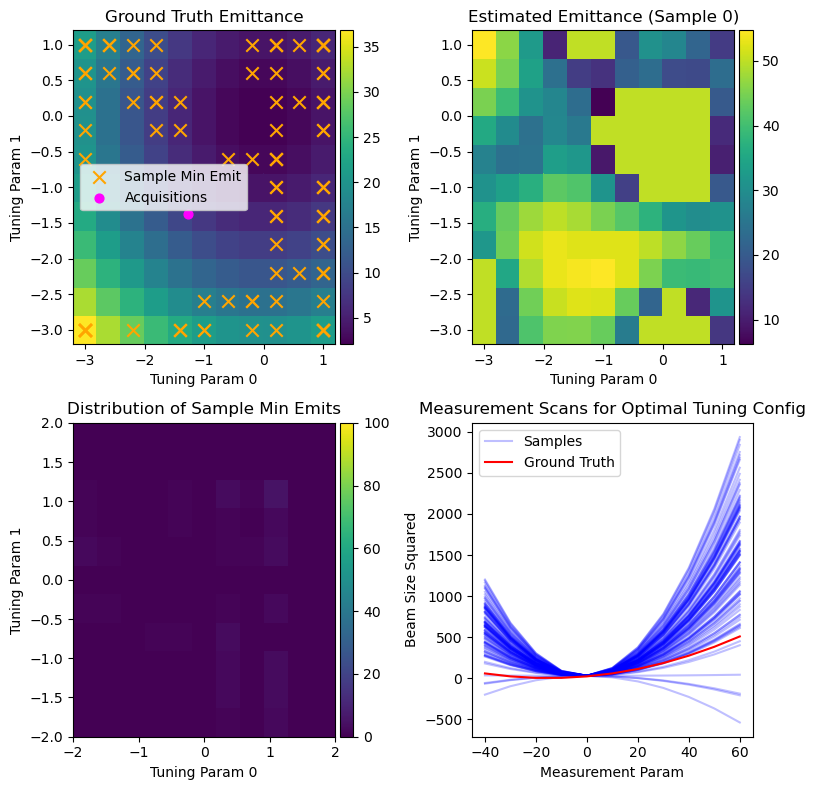

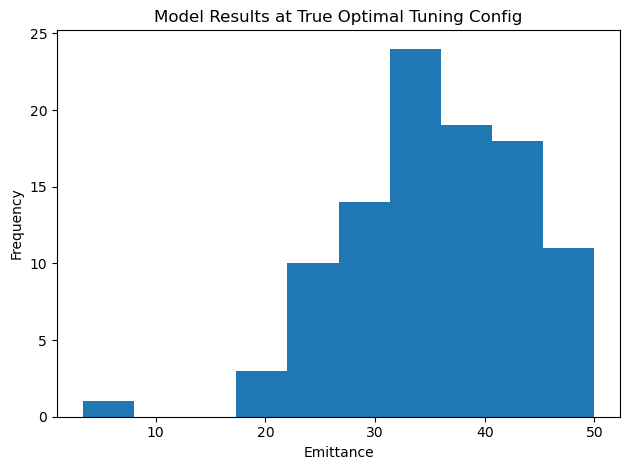

Iteration 2:
Results after 7 observations
Highest frequency =  15.0


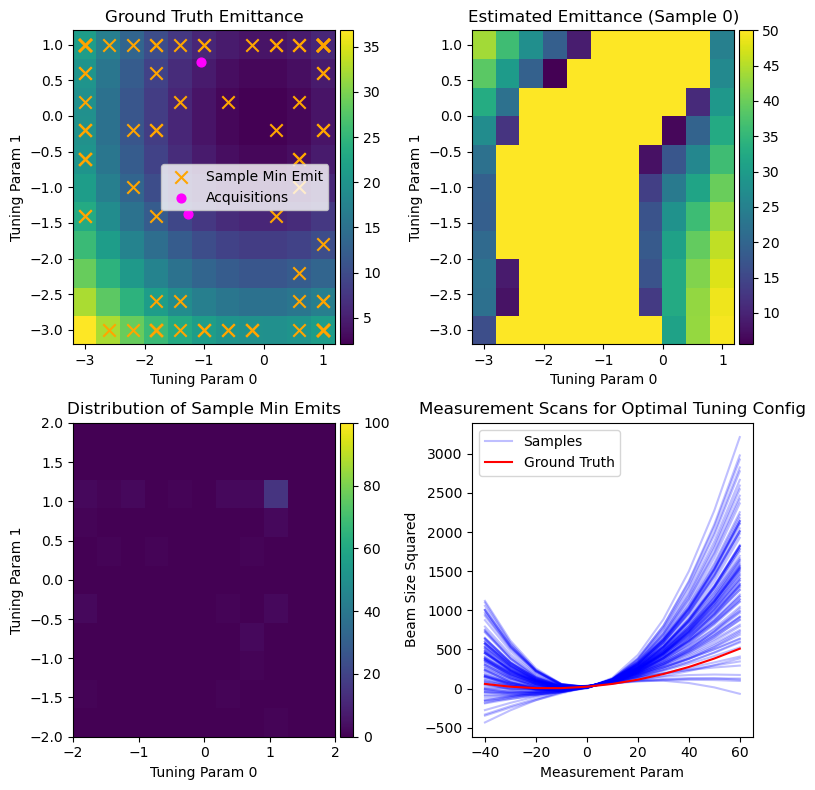

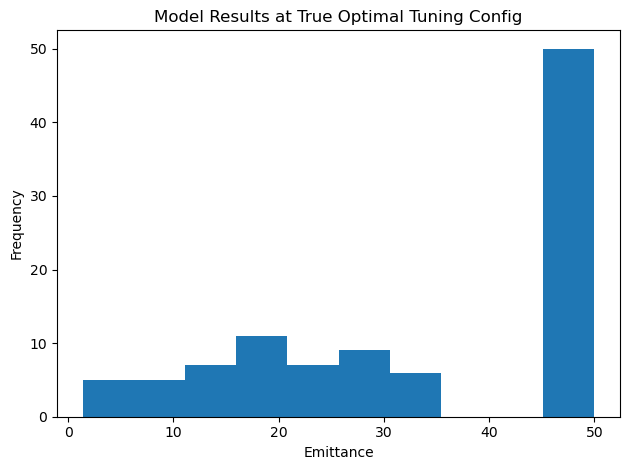

Iteration 3:
Results after 8 observations
Highest frequency =  11.0


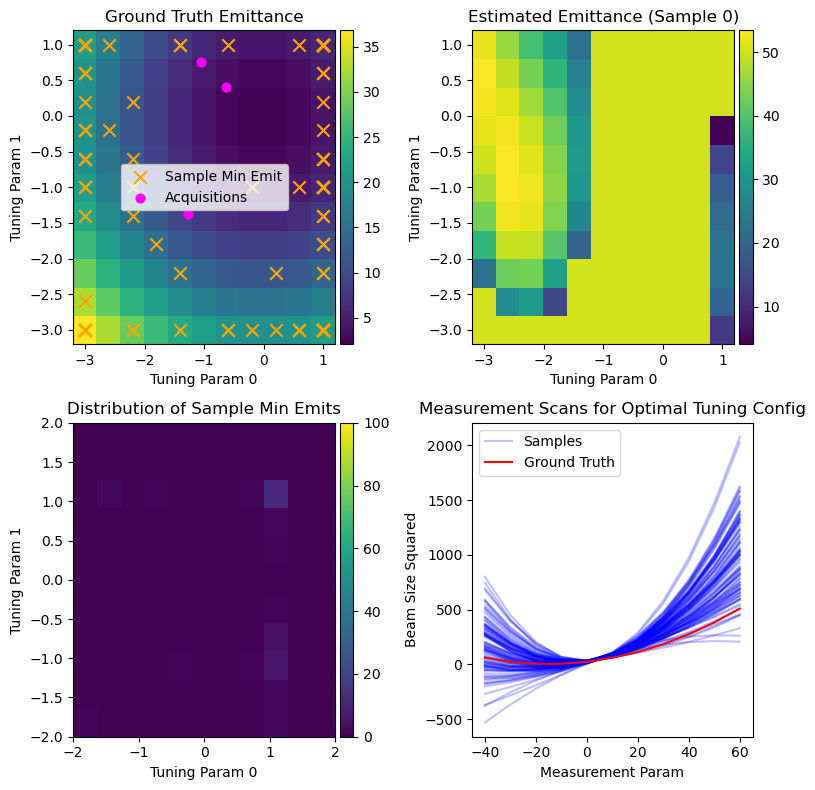

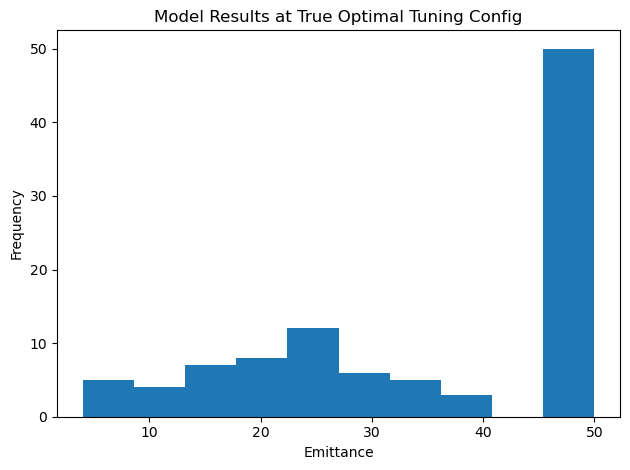

Iteration 4:
Results after 9 observations
Highest frequency =  1.0


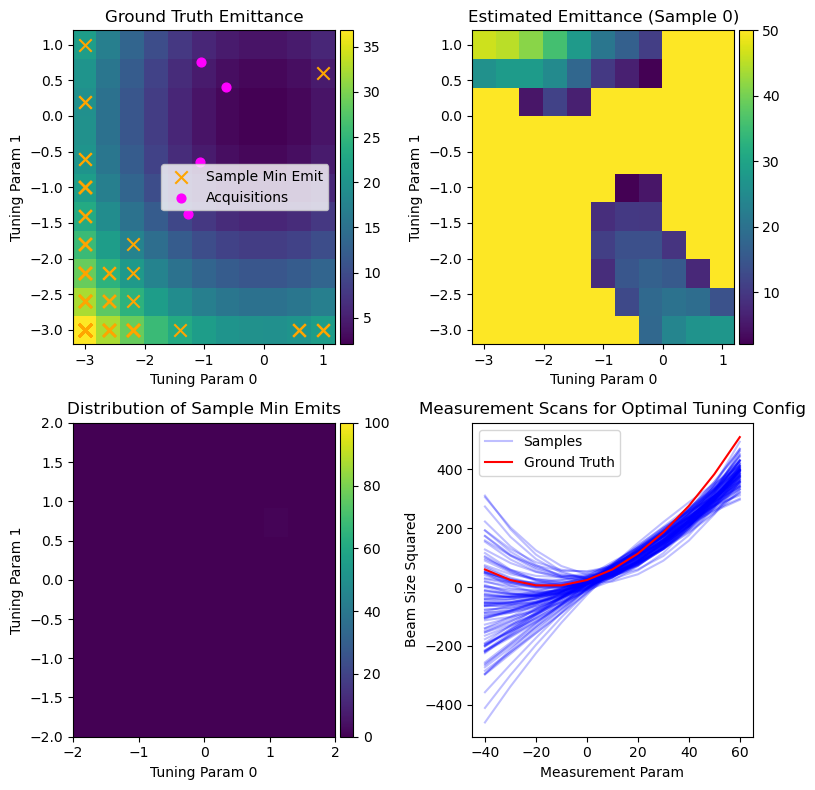

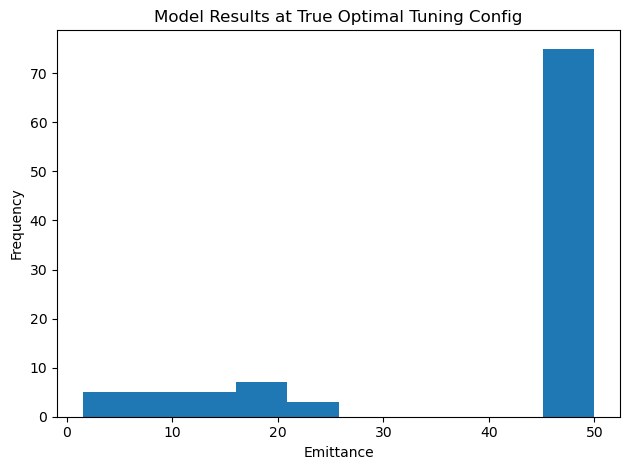

Iteration 5:
Results after 10 observations
Highest frequency =  2.0


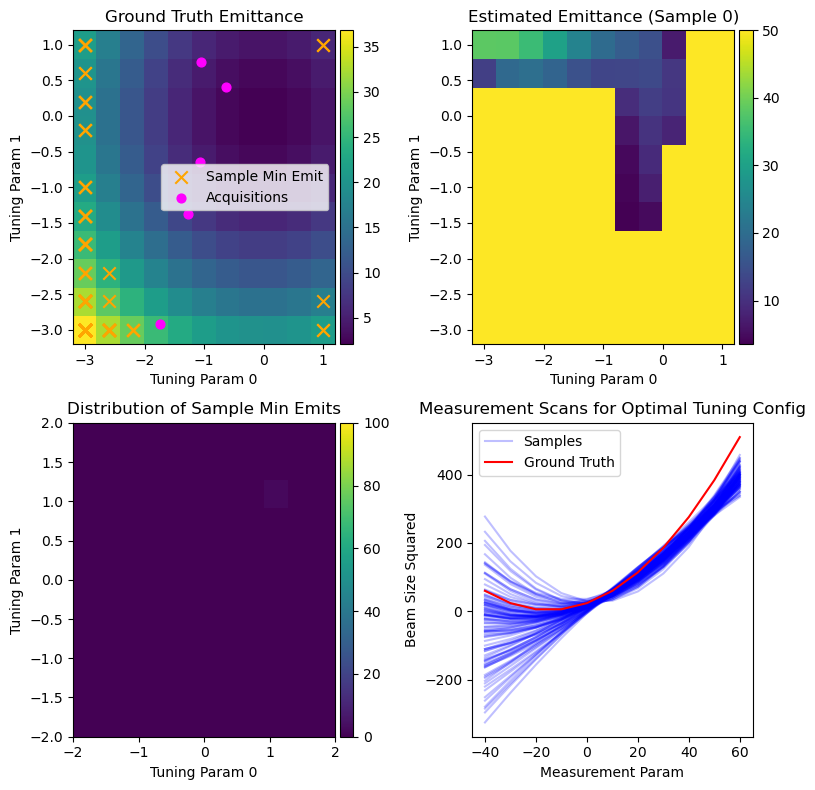

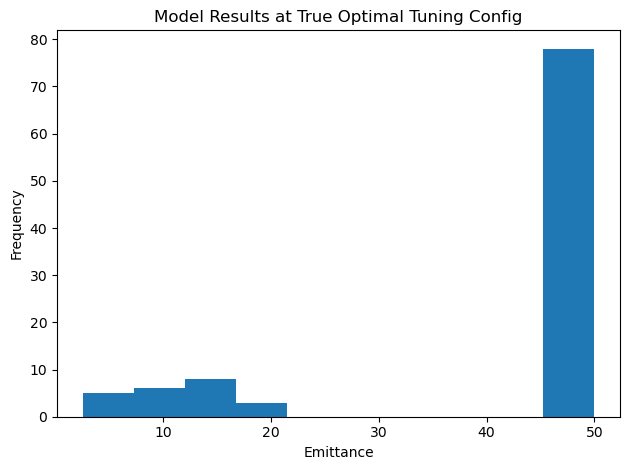

In [5]:
with open('MC-Emittance-NonPhys-Random-3d-Results-test.pkl', 'rb') as f:
    trial_data_test = dill.load(f)

dists_phys_rand, stds_phys_rand, gt_emits_at_x_star_pred_phys_rand = convergence_results(trial_data_test)

iter_plot3d(trial_data_test, 0, [1,2,3,4,5])

# Load

In [5]:
with open('MC-Emittance-Phys-Random-3d-Results.pkl', 'rb') as f:
    trial_data_phys_rand = dill.load(f)
trial_data = trial_data_phys_rand

dists_phys_rand, stds_phys_rand, gt_emits_at_x_star_pred_phys_rand = convergence_results()

del trial_data
del trial_data_phys_rand

In [6]:
with open('MC-Emittance-NonPhys-Random-3d-Results.pkl', 'rb') as f:
    trial_data_nonphys_rand = dill.load(f)
trial_data = trial_data_nonphys_rand

dists_nonphys_rand, stds_nonphys_rand, gt_emits_at_x_star_pred_nonphys_rand = convergence_results()

del trial_data
del trial_data_nonphys_rand

In [7]:
with open('MC-Emittance-Phys-BAX-3d-Results.pkl', 'rb') as f:
    trial_data_phys_bax = dill.load(f)
trial_data = trial_data_phys_bax

dists_phys_bax, stds_phys_bax, gt_emits_at_x_star_pred_phys_bax = convergence_results()

del trial_data
del trial_data_phys_bax

In [8]:
with open('MC-Emittance-NonPhys-BAX-3d-Results.pkl', 'rb') as f:
    trial_data_nonphys_bax = dill.load(f)
trial_data = trial_data_nonphys_bax

dists_nonphys_bax, stds_nonphys_bax, gt_emits_at_x_star_pred_nonphys_bax = convergence_results()

del trial_data
del trial_data_nonphys_bax

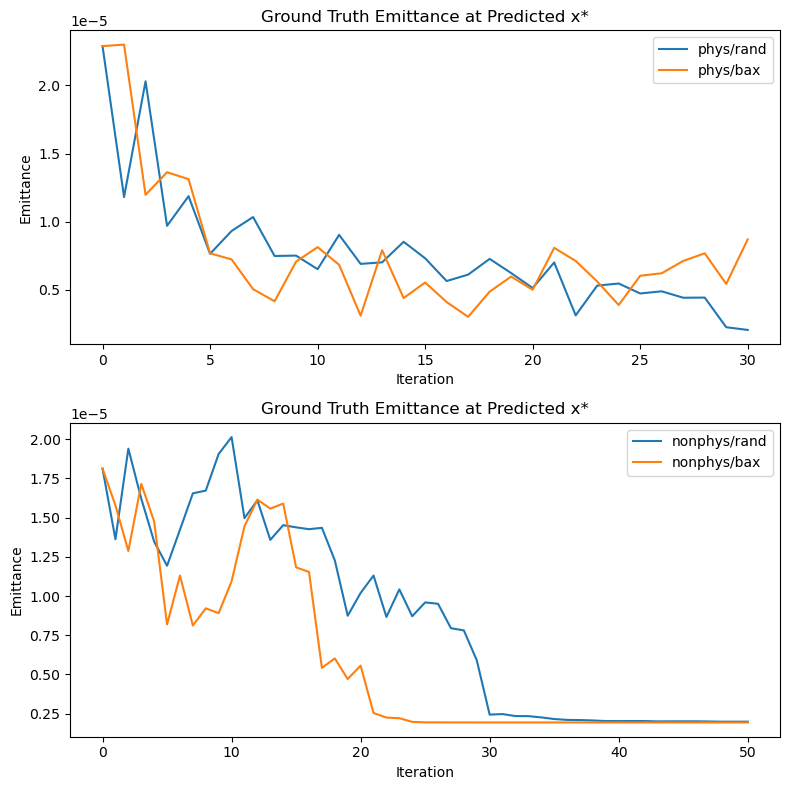

In [9]:
fig, axes = plt.subplots(2)
fig.set_size_inches((8, 8))

ax = axes[0]
ax.plot(torch.mean(gt_emits_at_x_star_pred_phys_rand, dim=0), label='phys/rand')
ax.plot(torch.mean(gt_emits_at_x_star_pred_phys_bax, dim=0), label='phys/bax')
ax.set_title('Ground Truth Emittance at Predicted x*')
ax.set_xlabel('Iteration')
ax.set_ylabel('Emittance')
ax.legend()


ax = axes[1]
ax.plot(torch.mean(gt_emits_at_x_star_pred_nonphys_rand, dim=0), label='nonphys/rand')
ax.plot(torch.mean(gt_emits_at_x_star_pred_nonphys_bax, dim=0), label='nonphys/bax')
ax.set_title('Ground Truth Emittance at Predicted x*')
ax.set_xlabel('Iteration')
ax.set_ylabel('Emittance')
ax.legend()

plt.tight_layout()

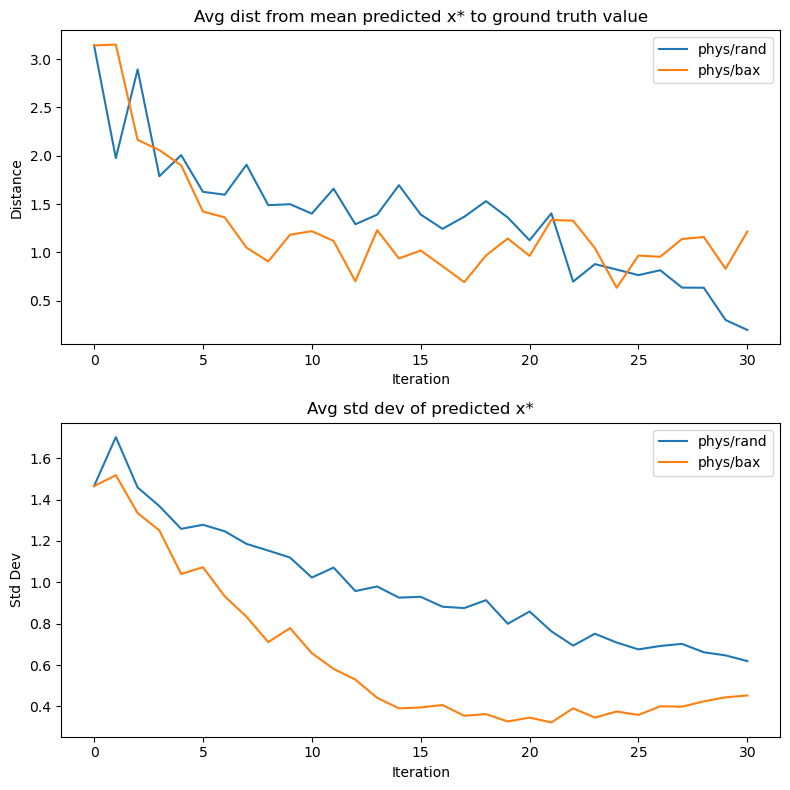

In [9]:
fig, axes = plt.subplots(2)
fig.set_size_inches((8, 8))

ax = axes[0]
ax.plot(torch.mean(dists_phys_rand, dim=0), label='phys/rand')
ax.plot(torch.mean(dists_phys_bax, dim=0), label='phys/bax')
ax.set_title('Avg dist from mean predicted x* to ground truth value')
ax.set_xlabel('Iteration')
ax.set_ylabel('Distance')
ax.legend()

ax = axes[1]
ax.plot(torch.mean(stds_phys_rand, dim=0), label='phys/rand')
ax.plot(torch.mean(stds_phys_bax, dim=0), label='phys/bax')
ax.set_title('Avg std dev of predicted x*')
ax.set_xlabel('Iteration')
ax.set_ylabel('Std Dev')
ax.legend()

plt.tight_layout()


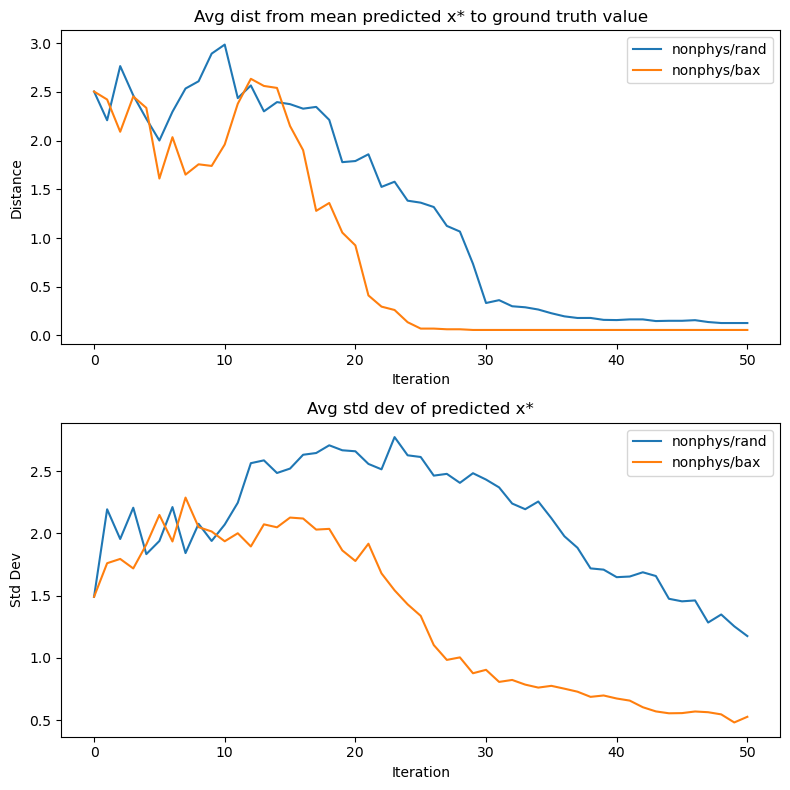

In [10]:
fig, axes = plt.subplots(2)
fig.set_size_inches((8, 8))

ax = axes[0]
ax.plot(torch.mean(dists_nonphys_rand, dim=0), label='nonphys/rand')
ax.plot(torch.mean(dists_nonphys_bax, dim=0), label='nonphys/bax')
ax.set_title('Avg dist from mean predicted x* to ground truth value')
ax.set_xlabel('Iteration')
ax.set_ylabel('Distance')
ax.legend()

ax = axes[1]
ax.plot(torch.mean(stds_nonphys_rand, dim=0), label='nonphys/rand')
ax.plot(torch.mean(stds_nonphys_bax, dim=0), label='nonphys/bax')
ax.set_title('Avg std dev of predicted x*')
ax.set_xlabel('Iteration')
ax.set_ylabel('Std Dev')
ax.legend()

plt.tight_layout()


Trial 2 

Iteration 5:
Results after 10 observations
Highest frequency =  5.0


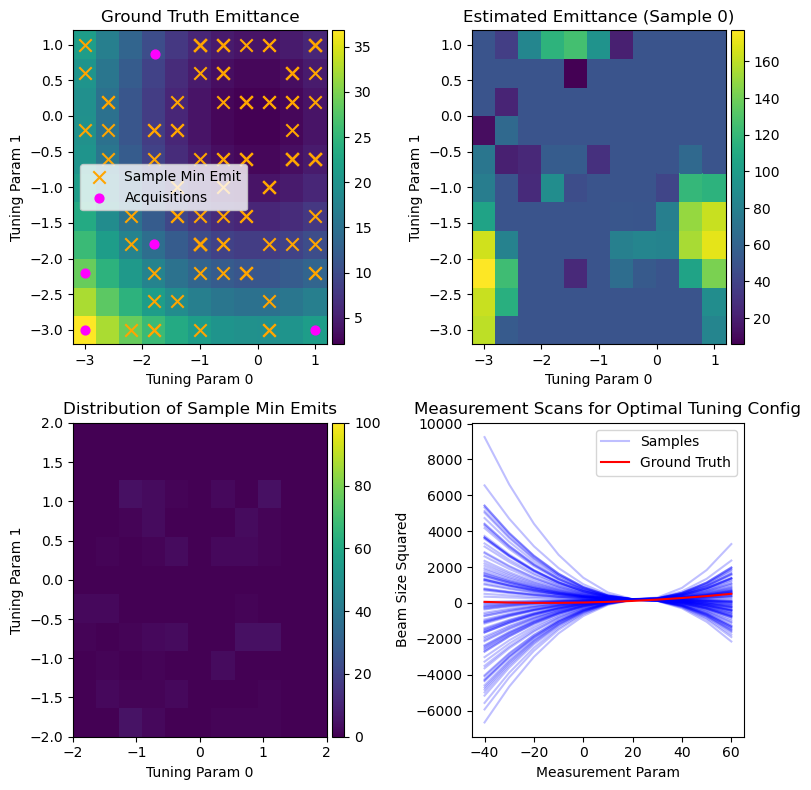

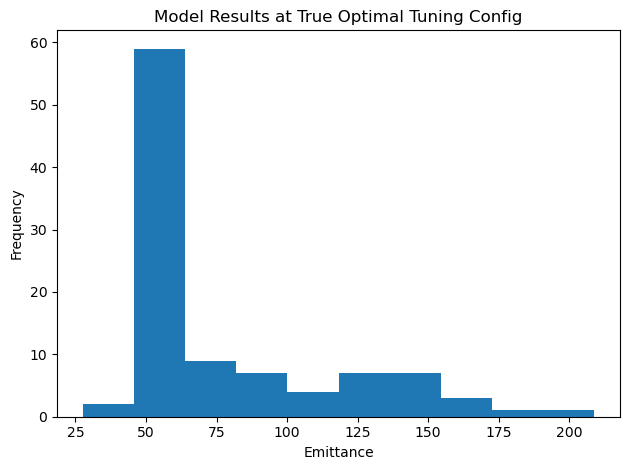

Iteration 10:
Results after 15 observations
Highest frequency =  7.0


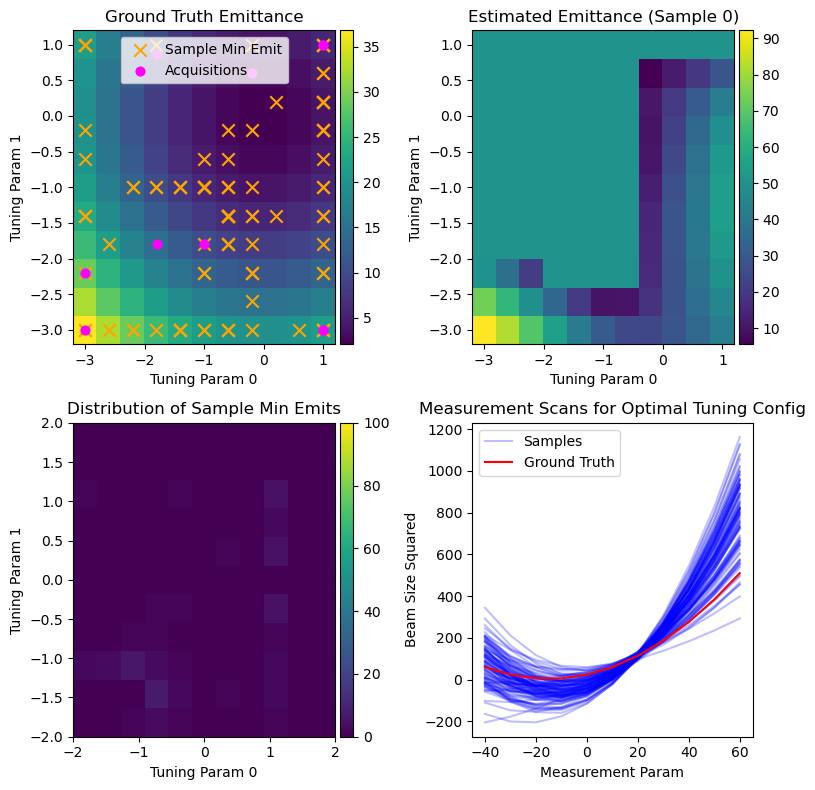

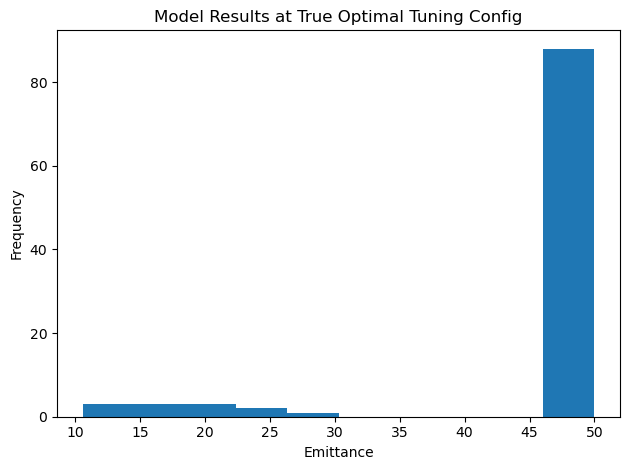

Iteration 15:
Results after 20 observations
Highest frequency =  7.0


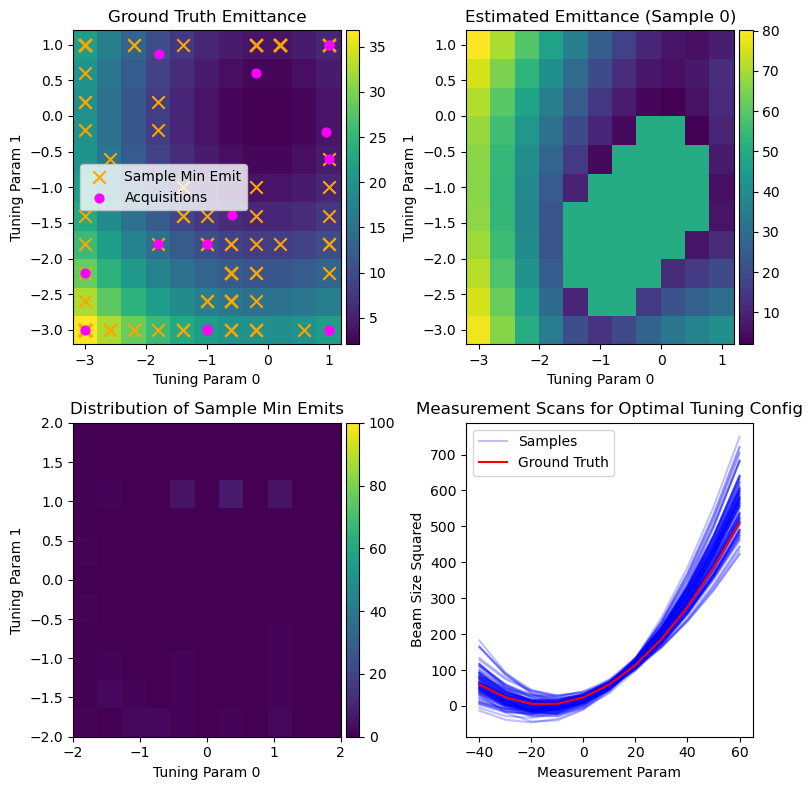

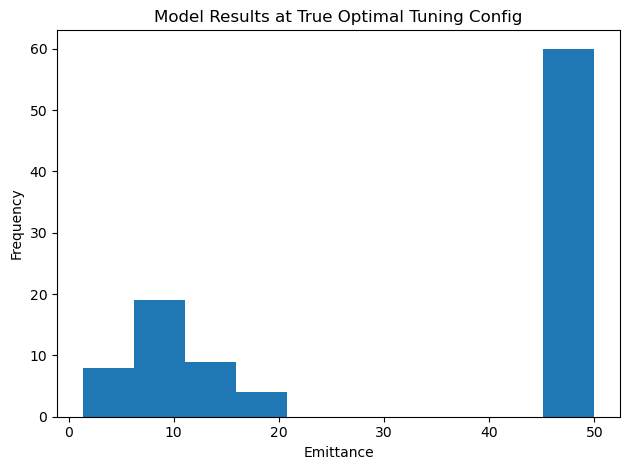

Iteration 20:
Results after 25 observations
Highest frequency =  14.0


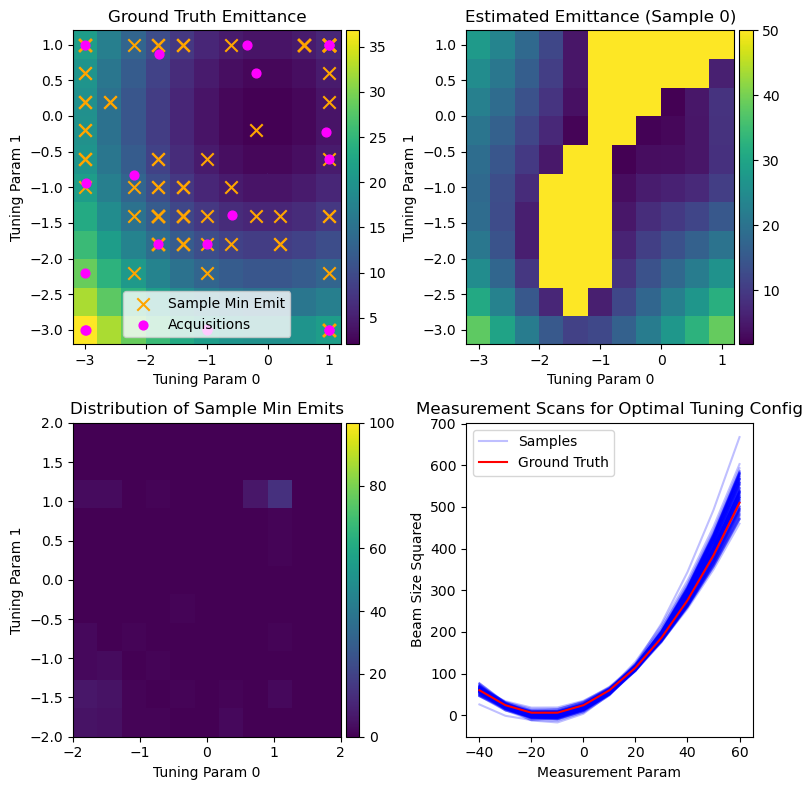

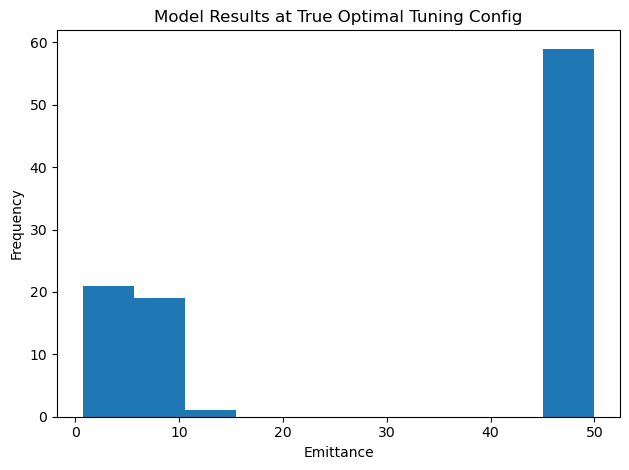

Iteration 25:
Results after 30 observations
Highest frequency =  12.0


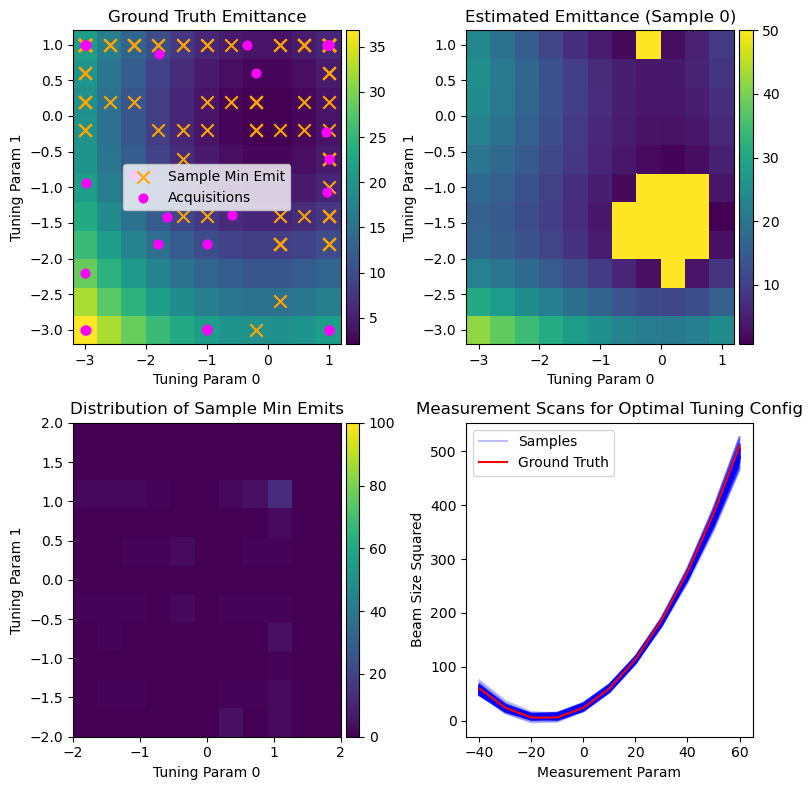

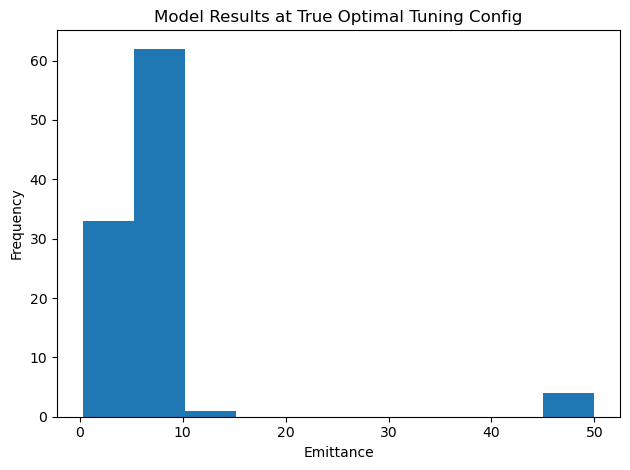

Iteration 30:
Results after 35 observations
Highest frequency =  8.0


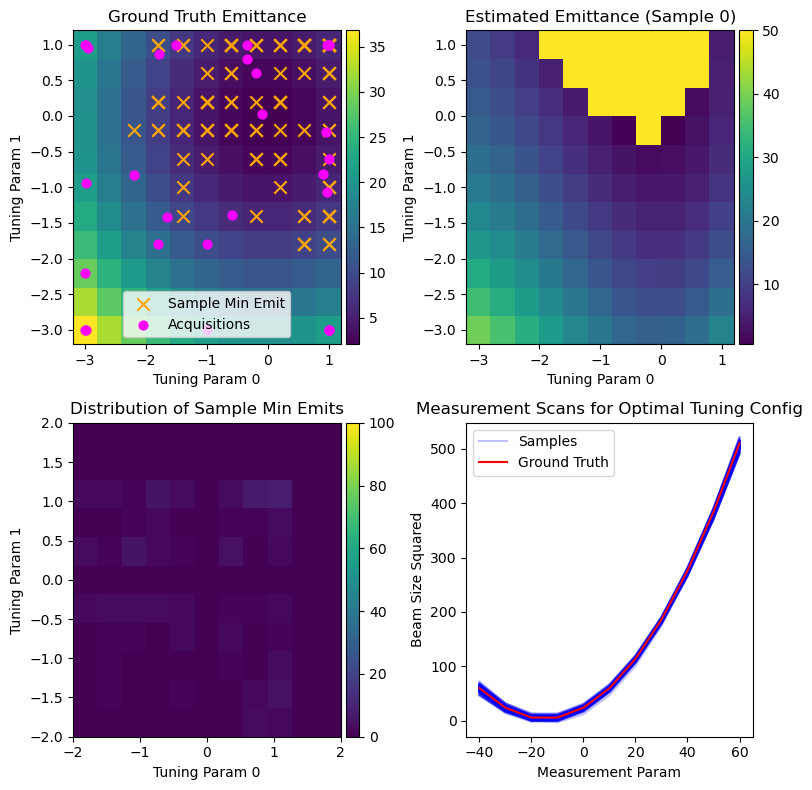

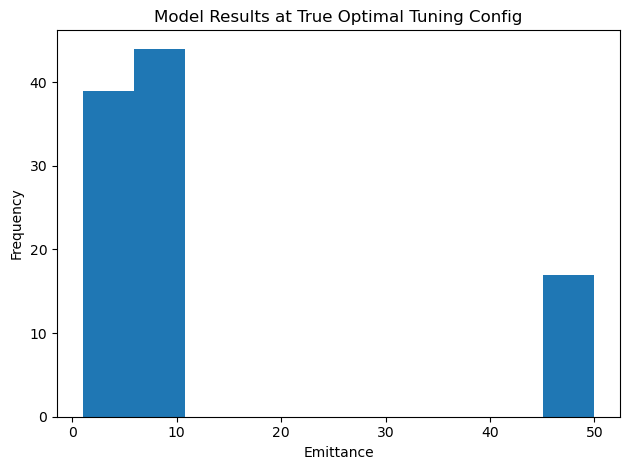

Iteration 35:
Results after 40 observations
Highest frequency =  11.0


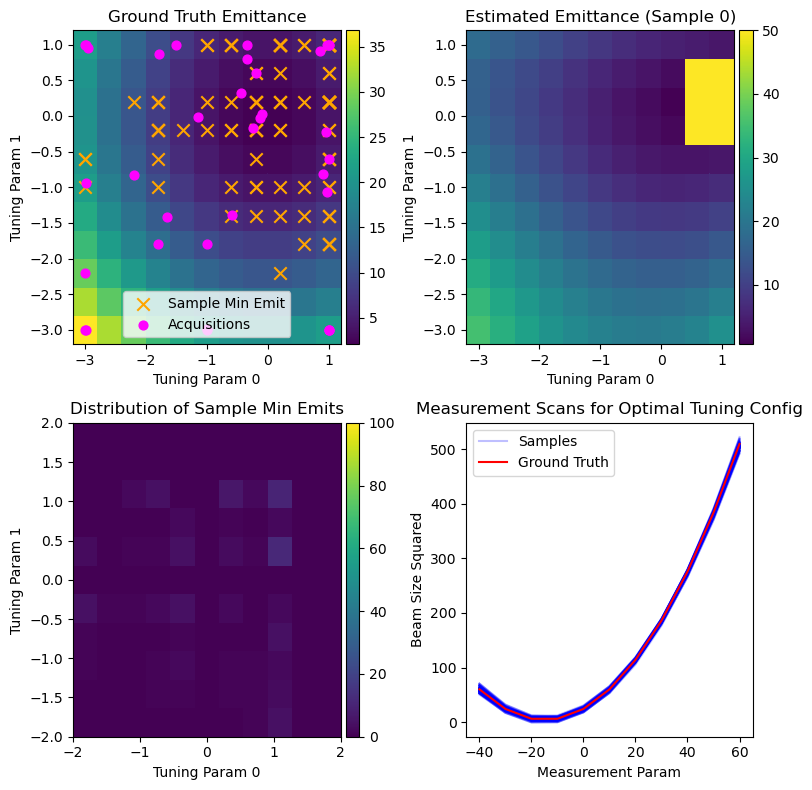

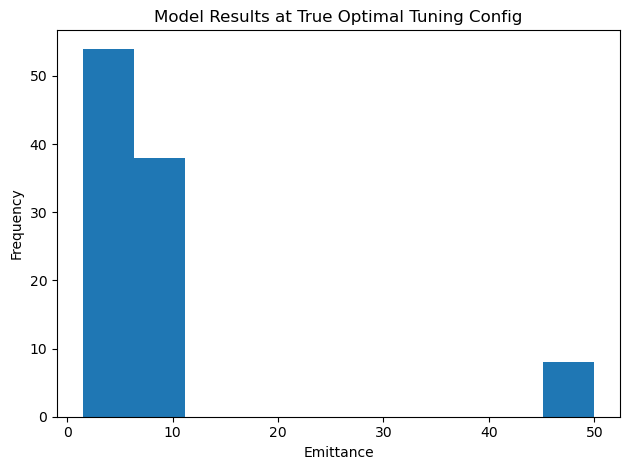

Iteration 40:
Results after 45 observations
Highest frequency =  8.0


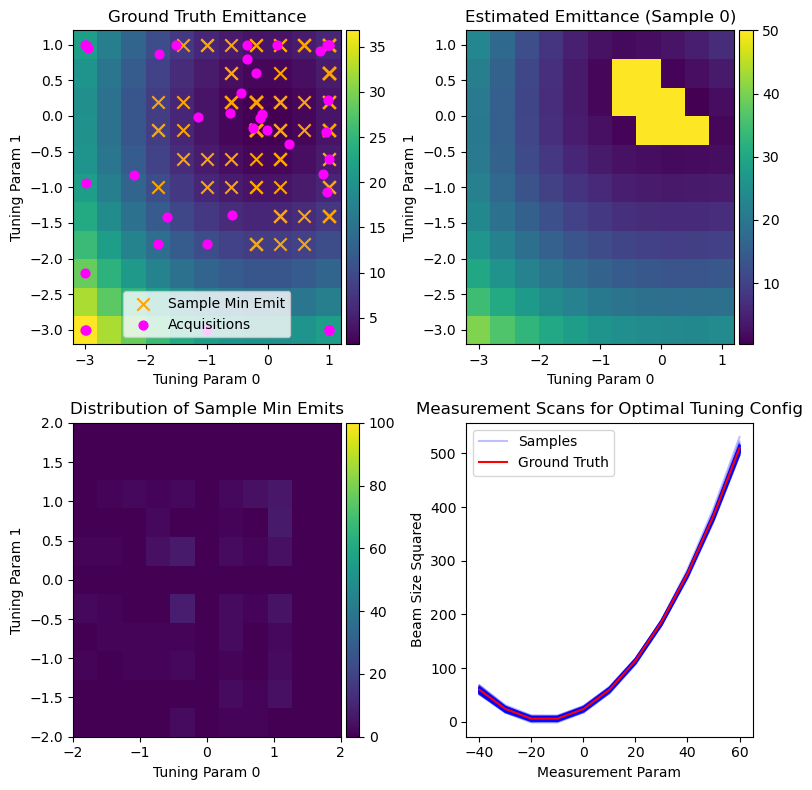

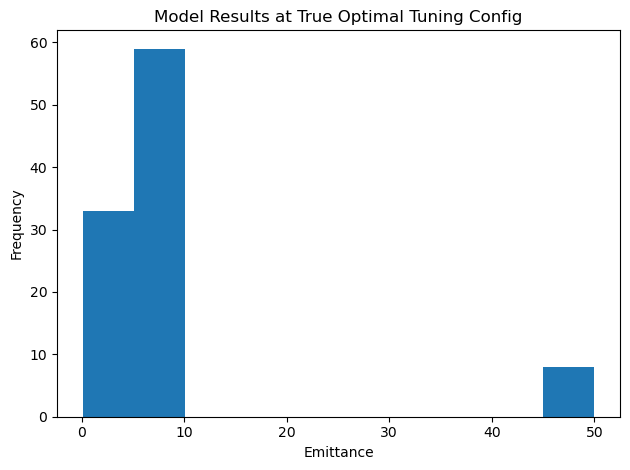

Iteration 45:
Results after 50 observations
Highest frequency =  12.0


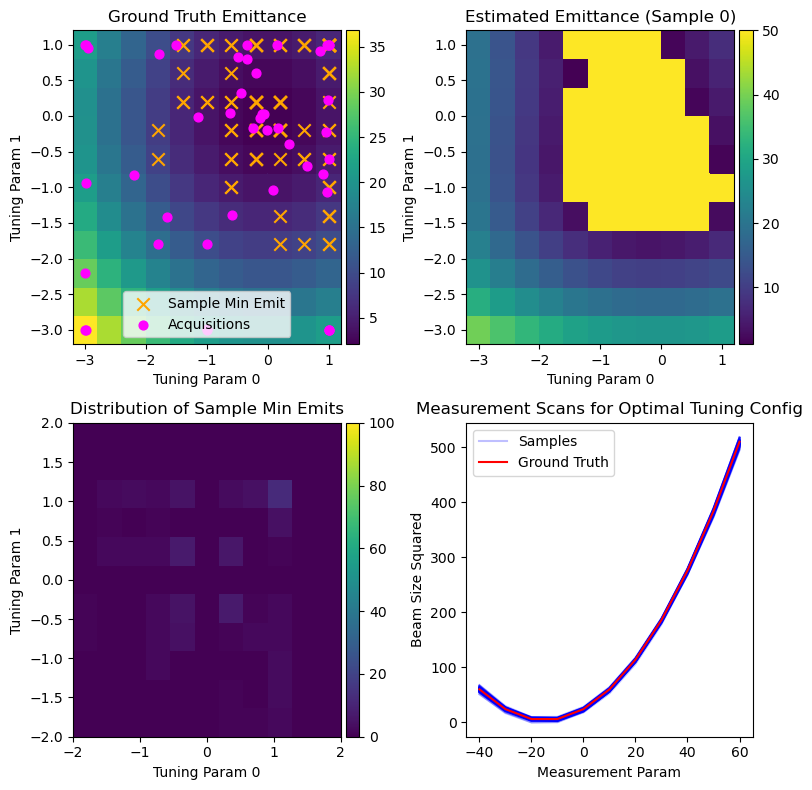

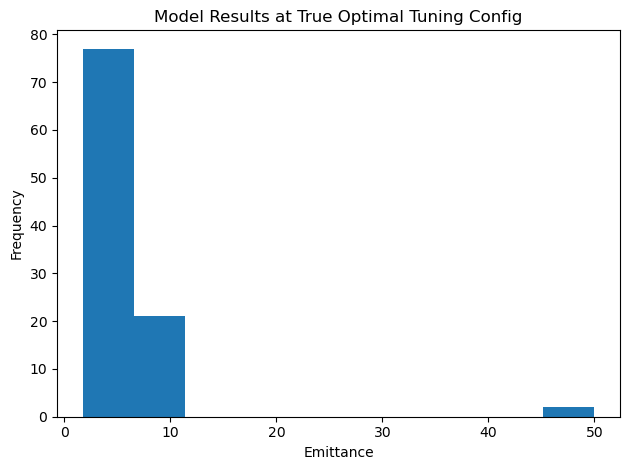

Iteration 50:
Results after 55 observations
Highest frequency =  10.0


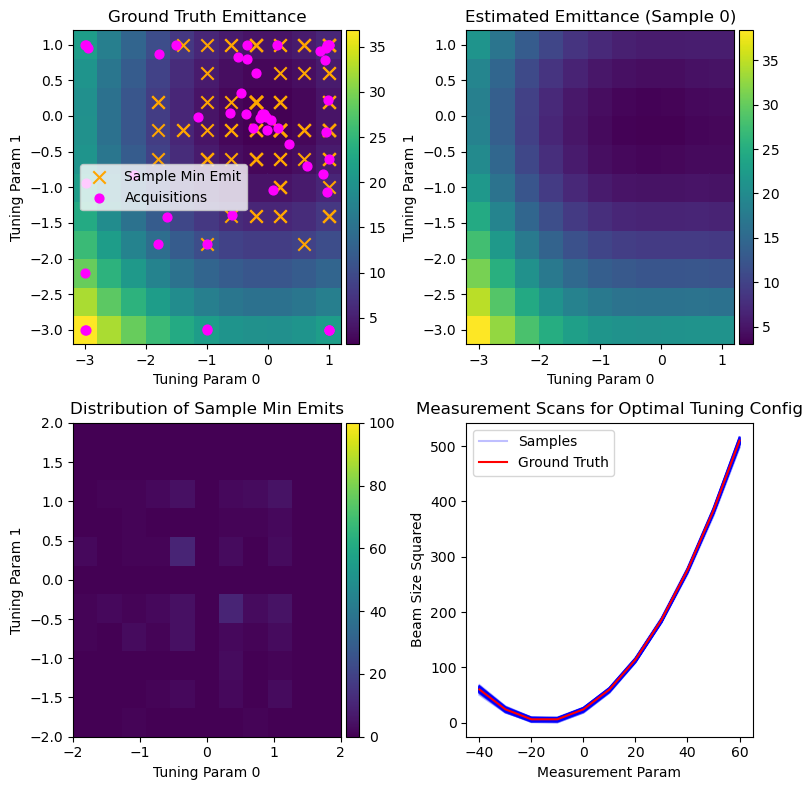

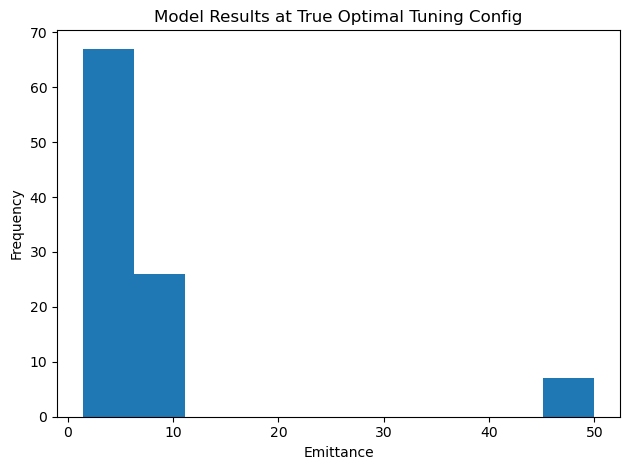

In [13]:
trial_data = trial_data_nonphys_bax
iter_plot3d(2,[5,10,15,20,25,30,35,40,45,50])

In [12]:
# import dill
# with open('MC-Emittance-Random-2d-Results.pkl', 'wb') as f:
#     dill.dump(trial_data, f)